In [1]:
import pandas as pd

df = pd.read_csv('../data/training.csv')
df = df.set_index('label')

### Group by and display count for each category
There are 12 categories of complaints

In [2]:
df.groupby(df.index).count()

,text
label,
Building Permission,2052
Drainage,2163
Electrical,3543
Encroachment,1376
Garbage,4007
Garden,1693
Health,2514
Property Tax,1487
Road,5347


In [3]:
# Creating a deep copy for training data
# df_for_training = df.copy()

In [4]:
# Make a dataset for training
# We are sampling 4000 entries per category, 
# thus minority classes are oversampled, ensuring that there is no imbalance in the dataset

# Q. What is the need to do this? 
# A. To resolve the bottleneck of having too few entries for some classes ~ 1400 
#    as well as too much for some classes ~16k. I have taken the number of samples as tunable,
#    and I arrived at the number 4000 just by hit and trial.

# STATE is used for producing replicable results
df_for_training = pd.DataFrame()
SAMPLES = 5000
STATE = 0

for i in list(set(df.index)):
    df_for_training = df_for_training.append(df.loc[i].sample(n=SAMPLES,random_state=STATE,replace=True))

In [5]:
df_for_training['class_label'] = df_for_training.index.factorize()[0]

In [6]:
# Since the classes are now numbered, I am storing this in a mapper.


import json

mapper_df = df_for_training[['class_label']].reset_index().groupby('label').mean()
mapper = mapper_df.to_dict()['class_label']
mapper = dict([(v, k) for k, v in mapper.items()])
mapper = dict(sorted(mapper.items()))

with open("../data/mapper.json", "w") as outfile:  
    json.dump(mapper, outfile) 

In [7]:
df_for_training = df_for_training.dropna()

In [8]:
df_for_training

,text,class_label
label,,
Traffic,yesterday i was to see outside the natural ice...,0
Traffic,can we remove the old breakdown from the road ...,0
Traffic,w w made have been closed without being this a...,0
Traffic,please remove illegal parking to d mart,0
Traffic,i want to know the status of bridge as it is n...,0
...,...,...
Encroachment,illegal,11
Encroachment,wale road ahet tari,11
Encroachment,anti encroachment drive going on on main it wa...,11


In [9]:
mapper

{0: 'Traffic',
 1: 'Stray Dogs',
 2: 'Property Tax',
 3: 'Electrical',
 4: 'Garden',
 5: 'Building Permission',
 6: 'Health',
 7: 'Garbage',
 8: 'Drainage',
 9: 'Water Supply',
 10: 'Road',
 11: 'Encroachment'}

### Let's begin training the model, now that we have our data

In [31]:
# importing libraries for the model

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC


import re
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manpreet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
# Initializing the stemmer, stopwords and the vectorizer

stemmer = PorterStemmer()
words = stopwords.words("english")
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True)


In [33]:
# Creating the input set by renaming columns and shuffling

X = df_for_training.copy() # Deep copy
X.columns = ['text','label']
X.index.name = None
X = X.reset_index()
X = X[['text','label']]
X = X.sample(frac=1)

In [34]:
X

,text,label
6516,there are at least stray dogs near chowk in th...,1
28700,i have made on and on in respect of illegal co...,5
59948,many doing notary business also hand and illegal,11
14312,we dont have any water pipe line supply by and...,2
7373,dog menace is in society one rabid dog one cor...,1
...,...,...
26389,we have reply to your notice but till not rece...,5
48729,water line break and leakage on link road at o...,9
28420,facing a security and health hazard due to una...,5
56132,pan stall che tari ya chi,11


In [35]:
# Creating the train-test split 
X['cleaned'] = X['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

x = X['cleaned']
y = X['label']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

Y_test = np.array(y_test)

In [36]:
# Initializing the models
models = {
            'RandomForest' : RandomForestClassifier(n_estimators=10,n_jobs=4,random_state=STATE),
            'LinearSVC' : LinearSVC(),
            'MultinomialNB' : MultinomialNB(),
            'LogisticRegression' : LogisticRegression(max_iter=200,random_state=STATE),
            'RBF_SVC' : SVC(probability=True,random_state=STATE)
#             'GBDT' : GradientBoostingClassifier()
         }

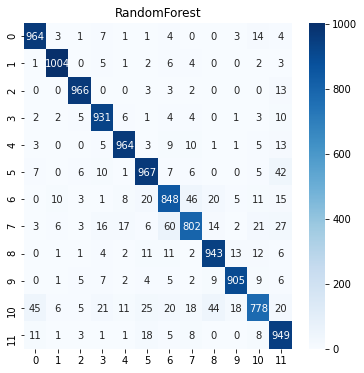

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1002
           1       0.97      0.98      0.97      1028
           2       0.97      0.98      0.97       987
           3       0.92      0.96      0.94       969
           4       0.95      0.95      0.95      1014
           5       0.91      0.92      0.92      1051
           6       0.86      0.86      0.86       987
           7       0.89      0.82      0.85       977
           8       0.91      0.94      0.93      1006
           9       0.95      0.95      0.95       955
          10       0.90      0.77      0.83      1011
          11       0.86      0.94      0.90      1005

    accuracy                           0.92     11992
   macro avg       0.92      0.92      0.92     11992
weighted avg       0.92      0.92      0.92     11992



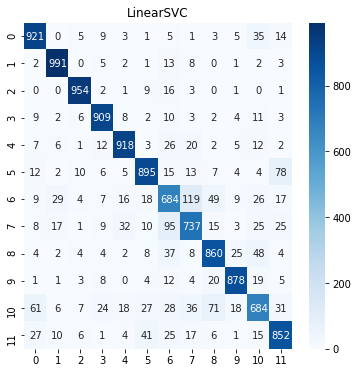

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1002
           1       0.93      0.96      0.95      1028
           2       0.95      0.97      0.96       987
           3       0.91      0.94      0.93       969
           4       0.91      0.91      0.91      1014
           5       0.88      0.85      0.86      1051
           6       0.71      0.69      0.70       987
           7       0.76      0.75      0.76       977
           8       0.83      0.85      0.84      1006
           9       0.92      0.92      0.92       955
          10       0.78      0.68      0.72      1011
          11       0.82      0.85      0.84      1005

    accuracy                           0.86     11992
   macro avg       0.86      0.86      0.86     11992
weighted avg       0.86      0.86      0.86     11992



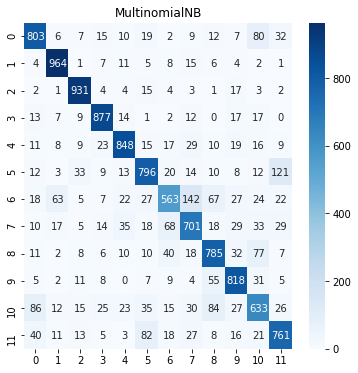

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      1002
           1       0.88      0.94      0.91      1028
           2       0.89      0.94      0.92       987
           3       0.88      0.91      0.89       969
           4       0.85      0.84      0.85      1014
           5       0.77      0.76      0.77      1051
           6       0.73      0.57      0.64       987
           7       0.70      0.72      0.71       977
           8       0.74      0.78      0.76      1006
           9       0.80      0.86      0.83       955
          10       0.67      0.63      0.65      1011
          11       0.75      0.76      0.75      1005

    accuracy                           0.79     11992
   macro avg       0.79      0.79      0.79     11992
weighted avg       0.79      0.79      0.79     11992



/home/manpreet/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


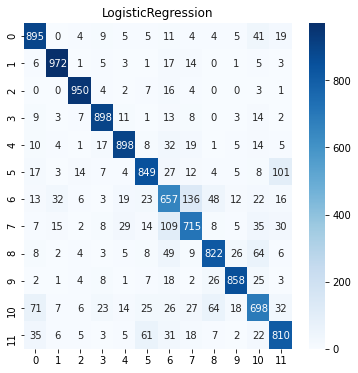

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1002
           1       0.93      0.95      0.94      1028
           2       0.95      0.96      0.95       987
           3       0.91      0.93      0.92       969
           4       0.90      0.89      0.89      1014
           5       0.84      0.81      0.82      1051
           6       0.65      0.67      0.66       987
           7       0.74      0.73      0.74       977
           8       0.84      0.82      0.83      1006
           9       0.91      0.90      0.91       955
          10       0.73      0.69      0.71      1011
          11       0.79      0.81      0.80      1005

    accuracy                           0.84     11992
   macro avg       0.84      0.84      0.84     11992
weighted avg       0.84      0.84      0.84     11992



In [ ]:
accuracies = {}
for model_name in list(models.keys()):
    pipeline = Pipeline([('vect', vectorizer),
#                          ('chi',  SelectKBest(chi2, k=1000)),
                         ('clf', models[model_name])])

    model = pipeline.fit(X_train, y_train)
    with open(f'{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)
        
    
    plt.figure(figsize=(6,6))
    plt.title(model_name)
    sns.heatmap(confusion_matrix(Y_test, model.predict(X_test)),annot=True,fmt='',cmap='Blues')
    plt.show()
    
    accuracies[model_name] = "{:.2f}".format(model.score(X_test, Y_test) * 100)
    print(classification_report(Y_test, model.predict(X_test)))

In [38]:
accuracies

{'RandomForest': '91.29',
 'LinearSVC': '80.04',
 'MultinomialNB': '76.13',
 'LogisticRegression': '79.25',
 'GBDT': '78.76'}

In [ ]:
models['RandomForest'].feature_importances_

In [19]:
# # Performing 5-fold cross validation for better selection of the model best suited

# pipelines = {}
# for model_name in list(models.keys()):
#     pipelines[model_name] = Pipeline([('vect', vectorizer),
#                          ('chi',  SelectKBest(chi2, k=1000)),
#                          ('clf', models[model_name])])

# CV = 5
# cv_df = pd.DataFrame(index=range(CV * len(models)))
# entries = []
# for model_name, model in pipelines.items():
#     accuracies = cross_val_score(model, x, y, scoring='accuracy', cv=CV)
#     for fold_idx, accuracy in enumerate(accuracies):
#         entries.append((model_name, fold_idx, accuracy))
# cv_df = pd.DataFrame(entries, columns=['Model Name', 'fold_idx', 'Accuracy'])

# plt.figure(figsize=(6,3))
# sns.stripplot(x='Model Name', y='Accuracy', data=cv_df, 
#               size=8, jitter=True, edgecolor="gray", linewidth=2)
# plt.show()

In [20]:
with open('RBF_SVC.pkl','rb') as file:
    model = pickle.load(file)

In [21]:
text = ['garbage not cleared near PEC campus']
query = [" ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower() for x in text]

mapper[model.predict(query)[0]]

'Garbage'

In [55]:
_features = pipeline[0].get_feature_names()
_support
_feature_importances = models['RandomForest'].feature_importances_

In [61]:
pipeline['chi']

SelectKBest(k=1000, score_func=<function chi2 at 0x7f3b614f3af0>)